# Chapter 3 | Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

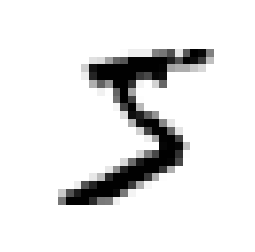

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_index = 0
some_digit = X[some_digit_index]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Getting the label associated to the `some_digit` example

In [4]:
y[some_digit_index]

'5'

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np

np.random.seed(42)

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifer

Let's start by creating a 5-detector as a binary classifier

In [7]:
y_train_5 = (y_train == y[some_digit_index]) # True for all 5s, False for all other digits.
y_test_5 = (y_test == y[some_digit_index])

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=3, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=3, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Mesures

### Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96355, 0.9563 , 0.9592 ])

We're over 95-96 % accuracy. Let's try a dumb classifier to compare.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53804,   775],
       [ 1644,  3777]], dtype=int64)

### Precision & Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score : {precision_score(y_train_5, y_train_pred):.3f}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred):.3f}")

Precision Score : 0.830
Recall Score : 0.697


### F1 Score

In [16]:
from sklearn.metrics import f1_score

print(f"F1 Score : {f1_score(y_train_5, y_train_pred):.3f}")

F1 Score : 0.757


### Precision/Recall Tradeoff

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(f"Score : {y_scores}")

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

Score : [1927.19381407]
[ True]


In [18]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [20]:
y_scores.shape

(60000,)

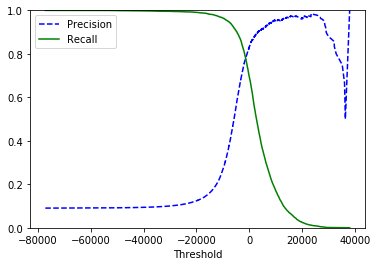

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

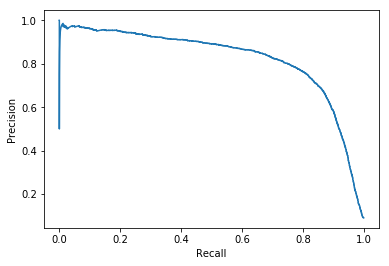

In [22]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [23]:
(y_train_pred == (y_scores > 0)).all()

True

In [24]:
y_train_pred_90 = (y_scores > 1500)

print(f"Precision Score : {precision_score(y_train_5, y_train_pred_90):.3f}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred_90):.3f}")

Precision Score : 0.870
Recall Score : 0.593


### The ROC Curve

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

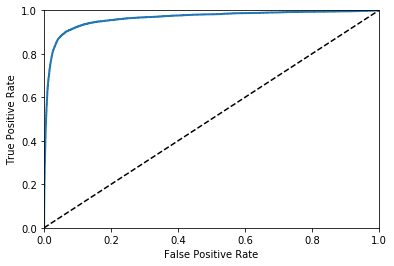

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Using the ROC AUC (Receiver Operating Characteristic Area Under Curve)

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9634516471318672

Train a RandomForestClassifier to compare ROC and ROC AUC

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

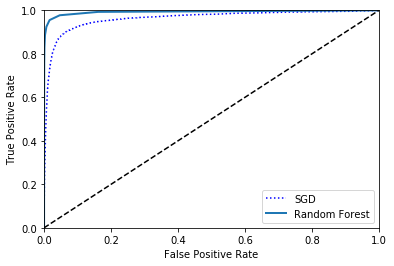

In [29]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
y_train_pred_90_forest = (y_scores_forest > 0.2)

print(f"ROC AUC Score : {roc_auc_score(y_train_5, y_scores_forest)}")
print(f"Precision Score : {precision_score(y_train_5, y_train_pred_90_forest)}")
print(f"Recall Score : {recall_score(y_train_5, y_train_pred_90_forest)}")

ROC AUC Score : 0.9928250745111685
Precision Score : 0.8523699802501645
Recall Score : 0.955358789891164


In [31]:
### p.93 | Multiclass Classification